## EEG Sleep states

In this tutorial, we just give a practical example how to use NLD properties in biomedical signals properties. In particular, we want to test whether NLD properties are better in the EEG sleep states classification compared to Powerband EEG.

Refer to the following tutorial to know more about the data and how to import them in Python

https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html

We are going to follow closely this tutorial and we are goign to add a part related DFA and Sampel Entropy to test whether these features have better predictive power that EEG powerband.

## Import packages

In [1]:
import numpy as np
import scipy as sp
from src import py_msent
import matplotlib.pyplot as plt
import fathon
from fathon import fathonUtils as fu
import math
import os
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nolds
from scipy.signal import welch

## Import MNE

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

## Polisomongraphy data

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/mariolavanga/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


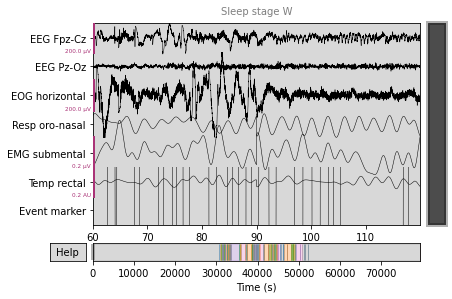

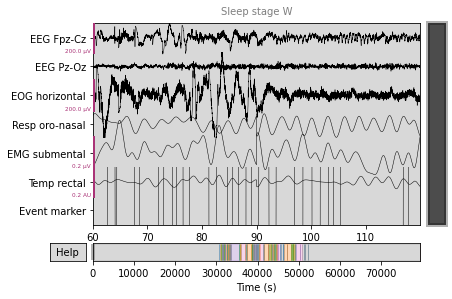

In [3]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'resp',
           'EMG submental': 'emg',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_train = mne.io.read_raw_edf(alice_files[0])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

## Extract 30s events from annotations

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


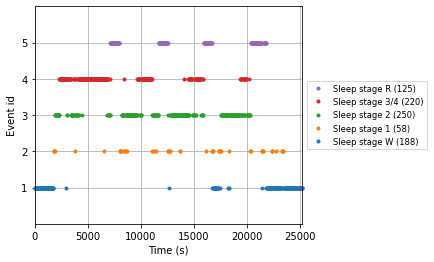

In [4]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Create Epochs from the data based on the events found in the annotations

In [5]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 - 29.99 sec, baseline off, ~13 kB, data not loaded,
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125
 'Sleep stage W': 188>


## Applying the same steps to the test data from Bob

In [6]:
raw_test = mne.io.read_raw_edf(bob_files[0])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
raw_test.set_channel_types(mapping)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from /Users/mariolavanga/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~13 kB, data not loaded,
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170
 'Sleep stage W': 157>


## Feature Engineering

Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 562 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS w

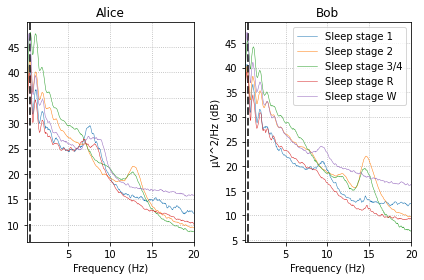

In [7]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='µV^2/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.tight_layout()
plt.show()


## Feature Engineering -- DFA

In [8]:
nMin = 16
nMax = 2**10
nScales = 32
exponents = np.linspace(np.log2(nMin), np.log2(nMax), nScales)
scales = np.round(np.power(2.0, exponents)).astype(np.int64)
q_list = [-5, -3, -1, 1, 3, 5]

In [9]:
def get_idxs(vec, scales):
    idxs = []
    for s in scales:
        idxs.append(np.where(vec==s)[0][0])
    return idxs

In [10]:
def test_mat_dfa(x):
    x_dfa = fathon.DFA(fu.toAggregated(x))
    n_w, F_w = x_dfa.computeFlucVec(scales, revSeg=False, polOrd=1)
    idxs = get_idxs(n_w, scales)
    n_w = n_w[idxs]
    F_w = F_w[idxs]
    H, _ = np.polyfit(np.log2(n_w), np.log2(F_w), 1)
    return H,n_w,F_w

Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 562 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 105 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 170 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 157 events and 3000 original time points ...
0 bad epochs dropped


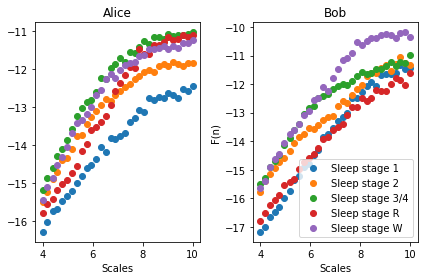

In [11]:
# visualize Alice vs. Bob DFA by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    stg_idx = 0
    for stage, color in zip(stages, stage_colors):
        x         = epochs[stage].get_data()
        eeg_x     = x[0,0,:]
        H,n_w,F_w = test_mat_dfa(eeg_x)
        ax.scatter(np.log2(n_w), np.log2(F_w),label=stages[stg_idx])
        stg_idx +=1
        
    ax.set(title=title, xlabel='Scales')
    
ax2.set(ylabel='F(n)')
# ax2.legend(ax2.lines[2::3], stages)
ax2.legend()
plt.tight_layout()
plt.show()


## Create NLD classifier and Powerband classifier


In [12]:
def eeg_nld(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    
    x          = epochs.get_data()
    
    X          = np.zeros([x.shape[0],3])
    for ep_idx in range(x.shape[0]):
#         print(['EPOCH-->',str(ep_idx)])
        eeg_x      = x[ep_idx,0,:]
        H,n_w,F_w  = test_mat_dfa(eeg_x)

        sd_x       = np.std(eeg_x, ddof=1)
        samp_en    = nolds.sampen(eeg_x, emb_dim=3, tolerance= 0.2*sd_x)

        NSEG       = (x.shape[0] + 1)/10
        NSEG_OV    = np.round(NSEG*0.5)
        f,PX       = welch(eeg_x, fs=1, window='hann', nperseg=NSEG, noverlap=NSEG_OV, nfft=None)

        f_loc      = np.where(f<0.1)[0]    
        beta, _    = np.polyfit(np.log10(f[f_loc[1:]]),np.log10(PX[f_loc[1:]]), 1)
        
        X[ep_idx,0] = H
        X[ep_idx,1] = samp_en
        X[ep_idx,2] = beta

    return X

In [13]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))
        
    print(np.concatenate(X, axis=1).shape)

    return np.concatenate(X, axis=1)

In [14]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
(841, 10)
Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
(1103, 10)
Accuracy score: 0.6699909338168631


In [15]:
pipe = make_pipeline(FunctionTransformer(eeg_nld, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
Loading data for 1103 events and 3000 original time points ...
Accuracy score: 0.6174070716228468
